In [1]:
from IPython.testing.tools import full_path
from pdf2image import convert_from_path
# import pytesseract
from PIL import Image
import camelot
import fitz  # PyMuPDF
import cv2
import numpy as np
import locale
from datetime import datetime
import os
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

In [2]:
pages = convert_from_path("../plannings_mensuels/planning.pdf", dpi=300)
for i, page in enumerate(pages):
    page.save(f"pages/page_{i}.png", "PNG")

In [95]:
text = pytesseract.image_to_string(Image.open("crop_cell/cell_5.png"), lang="fra")  # use "eng" if English
print(text)

In [64]:
data = pytesseract.image_to_data(Image.open("extracted_images/page1_Image6.jpeg"), lang="fra",
                                 output_type=pytesseract.Output.DATAFRAME)
print(data.head())


   level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
0      1         1          0        0         0         0     0    0    812   
1      2         1          1        0         0         0    25    0      1   
2      3         1          1        1         0         0    25    0      1   
3      4         1          1        1         1         0    25    0      1   
4      5         1          1        1         1         1    25    0      1   

   height  conf text  
0      32    -1  NaN  
1      32    -1  NaN  
2      32    -1  NaN  
3      32    -1  NaN  
4      32    95       


In [3]:
tables = camelot.read_pdf('../plannings_mensuels/planning.pdf', pages='all', line_scale=40)
tables

<TableList n=10>

In [4]:
tables[0].df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,ASSOCIATION LES JOURS HEUREUX\n(Réel)\nédition...,,,,,,,,,,...,,,,,,,,,,
1,salariés,,,,,,,,,,...,,,,,,,,,,
2,CONSTANT TCHAMDA MARIE\n0710000188,,,,,,,,,,...,,,,,,,,,,
3,MBALAZI TAMPO Jacqueline\nAMP\n18MBA03,,,,,,,,,,...,,,,,,,,,,
4,MBAYA Patricia\nAMP\n18MBA02,,,,,,,,,,...,,,,,,,,,,
5,"MIMOUN Chenounia, Mina\nADAMP\n18MIM01",,,,,,,,,,...,,,,,,,,,,
6,N'DZABA Destinée\n1810000356,,,,,,,,,,...,,,,,,,,,,
7,NDOUMBE NDEDI Harmelle\nAS\n18NDO01,,,,,,,,,,...,,,,,,,,,,
8,PROMENEUR Chantal\n1810000538,,,,,,,,,,...,,,,,,,,,,
9,SAKOA Gossi\nAS\n1810000502,,,,,,,,,,...,,,,,,,,,,


/tmp/ipykernel_25264/3717045681.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  camelot.plot(tables[0], kind='grid').show()


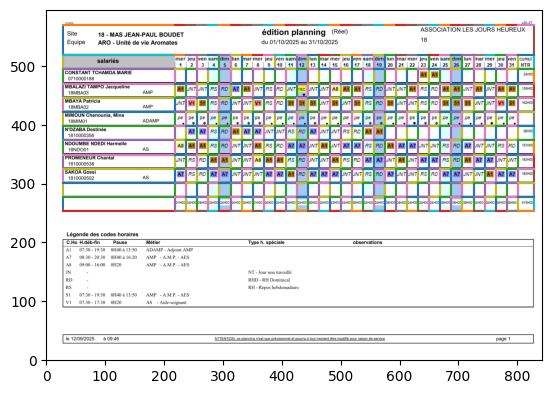

In [7]:
camelot.plot(tables[0], kind='grid').show()

In [59]:
tables = camelot.read_pdf('name.pdf', line_scale=40)
tables

/home/hicham/miniconda3/envs/phd/lib/python3.11/site-packages/camelot/parsers/base.py:124: UserWarning: page-1 is image-based, camelot only works on text-based pages.
  warnings.warn(


<TableList n=0>

In [10]:
img = cv2.imread("crop_cell/cell_6.png")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Binarize (thresholding)
_, thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

# Save preprocessed image
cv2.imwrite("clean_cell.png", thresh)

# OCR
text = pytesseract.image_to_string(Image.open("clean_cell.png"), lang="fra")
text


[ WARN:0@912.581] global loadsave.cpp:268 findDecoder imread_('crop_cell/cell_6.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
cv2.imshow("Gray Inverted", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
img = cv2.imread("extracted_images/page1_Image6.jpeg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [18]:
gray_inv = cv2.bitwise_not(gray)

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
vertical_lines = cv2.morphologyEx(gray_inv, cv2.MORPH_OPEN, kernel, iterations=2)

_, thresh = cv2.threshold(vertical_lines, 100, 255, cv2.THRESH_BINARY)

In [ ]:
cv2.imshow("Gray Inverted", gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
x_coords, = np.where(thresh[0] == 255)
x_coords = np.array(
    [x_coords[i] for i in range(len(x_coords) - 1) if x_coords[i] + 1 != x_coords[i + 1]] + [x_coords[-1]])
x_coords

array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
       325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625,
       650, 675, 700, 725, 750, 775, 811])

In [21]:
cells = []
for i in range(len(x_coords) - 1):
    x1, x2 = x_coords[i], x_coords[i + 1]
    cell = img[:, x1:x2]  # crop full height between two lines
    cells.append(cell)
    cv2.imwrite(f"crop_cell/cell_{i}.png", cell)

In [11]:
title = tables[0].df[0][0]
title

'ASSOCIATION LES JOURS HEUREUX\n(Réel)\nédition planning\nSite\n18 - MAS JEAN-PAUL BOUDET\n18\nEquipe\ndu 01/10/2025 au 31/10/2025\nARO - Unité de vie Aromates'

In [12]:
title.split('\n')

['ASSOCIATION LES JOURS HEUREUX',
 '(Réel)',
 'édition planning',
 'Site',
 '18 - MAS JEAN-PAUL BOUDET',
 '18',
 'Equipe',
 'du 01/10/2025 au 31/10/2025',
 'ARO - Unité de vie Aromates']

In [19]:
date = title.split('\n')[-2]
date = date.split(' ')[1]
date

'01/10/2025'

In [15]:
locale.setlocale(locale.LC_TIME, "fr_FR.UTF-8")

'fr_FR.UTF-8'

In [22]:
date = datetime(int(date.split('/')[-1]), int(date.split('/')[1]), int(date.split('/')[0]))
day_name = date.strftime("%A")
day_name

'mercredi'

In [120]:
def is_right_color(cell_image_path, reference_color):
    cell_image = cv2.imread(cell_image_path)
    distance = np.linalg.norm(cell_image - reference_color, axis=2)
    mask = np.uint8((distance < 50) * 255)

    # return mask
    return 25000 < mask.sum()

In [116]:
a1 = np.array([180, 120, 10])
a7 = np.array([130, 130, 250])
m1 = np.array([140, 255, 255])
str = np.array([0, 130, 250])
b7 = np.array([120, 120, 70])
b8 = np.array([140, 255, 50])
b9 = np.array([0, 130, 250])
ni = np.array([120, 20, 200])
nu = np.array([180, 120, 130])
mask = is_right_color("crop_cell/page5_cell_7_0.png", nu)

In [118]:
mask.sum()

38505

In [ ]:
a1 = np.array([180, 120, 10])
a7 = np.array([130, 130, 250])
m1 = np.array([140, 255, 255])
str = np.array([0, 130, 250])
b7 = np.array([120, 120, 70])
b8 = np.array([140, 255, 50])
b9 = np.array([0, 130, 250])
ni = np.array([120, 20, 200])
nu = np.array([180, 120, 130])
mask = is_right_color("crop_cell/page5_cell_7_0.png", nu)

In [117]:
img = cv2.imread("crop_cell/page5_cell_7_0.png")
cv2.imshow("", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [252]:
pdf_file = '../plannings_mensuels/planning.pdf'
doc = fitz.open(pdf_file)
doc[0]

page 0 of planning.pdf

In [121]:
def extract_images(pdf_file):
    doc = fitz.open(pdf_file)

    for i, page in enumerate(doc):
        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            name = img[7]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            if not os.path.exists("extracted_images"):
                os.mkdir("extracted_images")
            with open(f"extracted_images/page{i + 1}_{name}.{image_ext}", "wb") as f:
                f.write(image_bytes)

In [122]:
def extract_cells():
    for image_path in os.listdir("extracted_images"):
        image = cv2.imread(os.path.join("extracted_images", image_path))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_inv = cv2.bitwise_not(gray)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
        vertical_lines = cv2.morphologyEx(gray_inv, cv2.MORPH_OPEN, kernel, iterations=2)

        _, thresh = cv2.threshold(vertical_lines, 95, 255, cv2.THRESH_BINARY)


        x_coords, = np.where(thresh[0] == 255)
        x_coords = np.array(
            [x_coords[i] for i in range(len(x_coords) - 1) if x_coords[i] + 1 != x_coords[i + 1]] + [x_coords[-1]])

        cells = []
        for j in range(len(x_coords) - 1):
            x1, x2 = x_coords[j], x_coords[j + 1]
            cell = image[:, x1:x2]  # crop full height between two lines
            cells.append(cell)
            if not os.path.exists("crop_cell"):
                os.mkdir("crop_cell")
            cv2.imwrite(f"crop_cell/page{image_path.split('page')[-1].split('_')[0]}_cell_{image_path.split('page')[-1].split('Image')[1].split('.')[0]}_{j}.png", cell)

In [123]:
pdf_file = '../plannings_mensuels/planning.pdf'
locale.setlocale(locale.LC_TIME, "fr_FR.UTF-8")

extract_images(pdf_file)
extract_cells()

planning = {}
color_codes = {
    'ARO': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))],
    'LAV': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))],
    'NUI': [('9:00-12:00', np.array([120, 120, 70])), ('13:00-16:30', np.array([140, 255, 50])),
            ('8:30-12:00', np.array([0, 130, 250])), ('20:00-8:00', np.array([120, 20, 200])),
            ('20:30-7:30', np.array([180, 120, 130]))],
    'ORA': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))],
    'ROS': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250])),
            ('7:30-14:30', np.array([140, 255, 255])), ('7:30-14:30', np.array([0, 130, 250]))],
    'TUL': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))]
}

tables = camelot.read_pdf(pdf_file, pages='all', line_scale=40)
title = tables[0].df[0][0]

dates = title.split('\n')[-2]
upper_date = dates.split(' ')[-1]
lower_date = dates.split(' ')[1]
processed_date_day = int(lower_date.split('/')[0])
day_number = 0

while processed_date_day <= int(upper_date.split('/')[0]):
    date = datetime(int(dates.split('/')[-1]), int(dates.split('/')[1]), processed_date_day)
    day_name = date.strftime("%A")
    with open("planning.txt", "a") as f:
        f.write(f"\n{day_name} {processed_date_day}/{dates.split('/')[1]}/{dates.split('/')[-1]}\n")
        for page_number, table in enumerate(tables):
            title = table.df[0][0]
            service = title.split('\n')[-1].split(' ')[0]
            if service in color_codes.keys():
                f.write(f"\n{title.split('\n')[-1]}\n")
                name_list = np.array(table.df[0][2::])
                name_list = name_list[name_list != '']
                for color_code in color_codes[service]:
                    for i, name in enumerate(name_list):
                        if is_right_color(f"crop_cell/page{page_number+1}_cell_{i+2}_{day_number}.png", color_code[1]):
                            f.write(f"{color_code[0]} - {name.split('\n')[0]}\n")

    processed_date_day += 1
    day_number += 1

In [ ]:
planning

In [ ]:
title = tables[8].df[0][0]
title.split('\n')[-1].split(' ')[0]

In [29]:
name_list = np.array(tables[0].df[0][2::])
name_list = name_list[name_list != '']
name_list[2].split('\n')[0]

'MBAYA Patricia'

In [132]:
pdf_file = '../plannings_mensuels/planning.pdf'
locale.setlocale(locale.LC_TIME, "fr_FR.UTF-8")

extract_images(pdf_file)
extract_cells()

planning = {}
color_codes = {
    'ARO': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))],
    'LAV': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))],
    'ORA': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))],
    'ROS': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250])),
            ('7:30-14:30', np.array([140, 255, 255])), ('7:30-14:30', np.array([0, 130, 250]))],
    'TUL': [('7:30-19:30', np.array([180, 120, 10])), ('8:30-20:30', np.array([130, 130, 250]))],
    'NUI': [('9:00-12:00', np.array([120, 120, 70])), ('13:00-16:30', np.array([140, 255, 50])),
            ('8:30-12:00', np.array([0, 130, 250])), ('20:00-8:00', np.array([120, 20, 200])),
            ('20:30-7:30', np.array([180, 120, 130]))]
}

tables = camelot.read_pdf(pdf_file, pages='all', line_scale=40)
title = tables[0].df[0][0]

dates = title.split('\n')[-2]
upper_date = dates.split(' ')[-1]
lower_date = dates.split(' ')[1]
processed_date_day = int(lower_date.split('/')[0])
day_number = 0

while processed_date_day <= int(upper_date.split('/')[0]):
    date = datetime(int(dates.split('/')[-1]), int(dates.split('/')[1]), processed_date_day)
    day_name = date.strftime("%A")
    planning[f"{day_name} {processed_date_day}/{dates.split('/')[1]}/{dates.split('/')[-1]}"] = {}
    for page_number, table in enumerate(tables):
        title = table.df[0][0]
        service = title.split('\n')[-1].split(' ')[0]
        if service in color_codes.keys():
            planning[f"{day_name} {processed_date_day}/{dates.split('/')[1]}/{dates.split('/')[-1]}"][title.split('\n')[-1]] = []
            name_list = np.array(table.df[0][2::])
            name_list = name_list[name_list != '']
            for color_code in color_codes[service]:
                for i, name in enumerate(name_list):
                    if is_right_color(f"crop_cell/page{page_number+1}_cell_{i+2}_{day_number}.png", color_code[1]):
                        planning[f"{day_name} {processed_date_day}/{dates.split('/')[1]}/{dates.split('/')[-1]}"][title.split('\n')[-1]].append(f"{color_code[0]} - {name.split('\n')[0]}")

    processed_date_day += 1
    day_number += 1

In [137]:
doc = SimpleDocTemplate("../planning_table.pdf", pagesize=A4)
styles = getSampleStyleSheet()
story = []

for idx, (day, units) in enumerate(planning.items()):
    story.append(Paragraph(f"<b>{day}</b>", styles["Title"]))
    story.append(Spacer(1, 12))

    table_data = [["Unité", "Horaires & Personnes", "Stagiaire"]]

    for unit, shifts in units.items():
        shift_text = "<br/>".join(shifts)
        table_data.append([
            unit,
            Paragraph(shift_text, styles["Normal"]),
            ""
        ])

    table = Table(table_data, colWidths=[160, 230, 120])
    table.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
        ("TEXTCOLOR", (0,0), (-1,0), colors.black),
        ("ALIGN", (0,0), (-1,-1), "LEFT"),
        ("VALIGN", (0,0), (-1,-1), "TOP"),
        ("FONTNAME", (0,0), (-1,0), "Helvetica-Bold"),
        ("GRID", (0,0), (-1,-1), 0.5, colors.black),
        ("ROWBACKGROUNDS", (0,1), (-1,-1), [colors.whitesmoke, colors.lightyellow]),
    ]))

    story.append(table)

    if idx < len(planning) - 1:
        story.append(PageBreak())

doc.build(story)
